### Imaging of galaxies

The purpose of the exercise is to image a galaxy and estimate its diameter.

- conda install astropy

- Astronomical images come in FITS format

https://en.wikipedia.org/wiki/FITS

- Let's download an image from: https://www2.mpia-hd.mpg.de/THINGS/Data.html

In [1]:
from astropy.io import fits

To open a FITS file, you can use fits.open()

In [2]:
hdu1 = fits.open("./sample_data/NGC_3184_NA_MOM0_THINGS.FITS")

print(type(hdu1))

<class 'astropy.io.fits.hdu.hdulist.HDUList'>


#### Print the header:

In [30]:
header = hdu1[0].header.keys

print(hdu1[0].header.keys)

<bound method Header.keys of SIMPLE  =                    T /                                                
BITPIX  =                  -32 /                                                
NAXIS   =                    4 /                                                
NAXIS1  =                 1024 /                                                
NAXIS2  =                 1024 /                                                
NAXIS3  =                    1 /                                                
NAXIS4  =                    1 /                                                
EXTEND  =                    T /Tables following main image                     
BLOCKED =                    T /Tape may be blocked                             
OBJECT  = 'NGC3184 '           /Source name                                     
TELESCOP= 'VLA     '           /                                                
INSTRUME= 'VLA     '           /                                                

#### Inspect the data:

In [4]:
data = hdu1[0].data

print(type(data))
print(data.shape)
print(data)

<class 'numpy.ndarray'>
(1, 1, 1024, 1024)
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]


In [5]:
# Get the data into a 2D array:

data_2D = data[0,0,:,:]

print(data_2D.shape)

(1024, 1024)


### Imaging:

In [6]:
import matplotlib.pyplot as plt

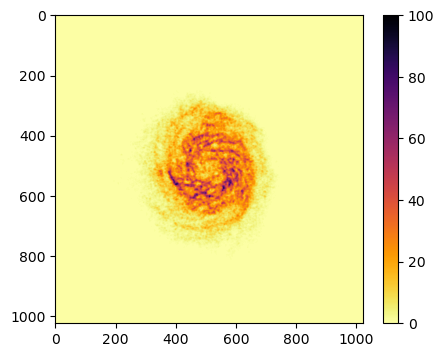

In [7]:
# Figure environment

fig, ax = plt.subplots(figsize=(5,4))

Z = ax.imshow(data_2D, cmap = "inferno_r", vmin = 0., vmax = 100.)

plt.colorbar(Z)

plt.show()

### Exercise: Calculating the diameter of this galaxy

In [8]:
import numpy as np

#### 1. Pixel histogram

In [9]:
# Flatten the array
print(data_2D.size)

data_1D = data_2D.reshape((data_2D.size, 1))

print(data_1D.size)

1048576
1048576


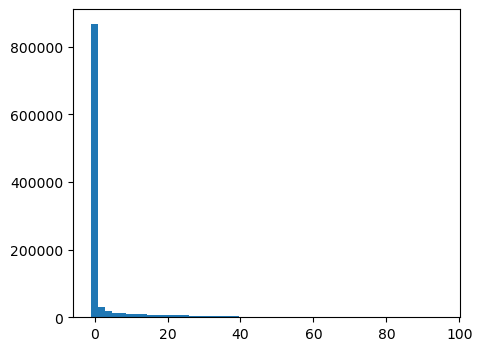

In [10]:
# Plotting the histogram

plt.figure(figsize=(5,4))

plt.hist(data_1D, bins = 50)

plt.show()

In [11]:
# Pixel min/max:

print(np.min(data_1D), np.max(data_1D))

-1.0854306 95.46323


#### 2. Isolating features (getting rid of the background):



In [12]:
# Let's use conditionals
data_1D_clean = np.where(data_1D < 10., np.nan, data_1D)

# Reshape into a 2D cleaned image

data_2D_clean = data_1D_clean.reshape(data_2D.shape)

print(data_1D_clean.shape, data_2D_clean.shape)

(1048576, 1) (1024, 1024)


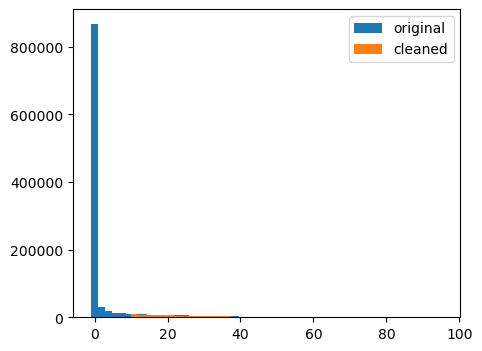

In [13]:
# Plotting the histogram

plt.figure(figsize=(5,4))
plt.hist(data_1D, bins = 50, label = "original")
plt.hist(data_1D_clean, bins = 50, label = "cleaned")
plt.legend()
plt.show()

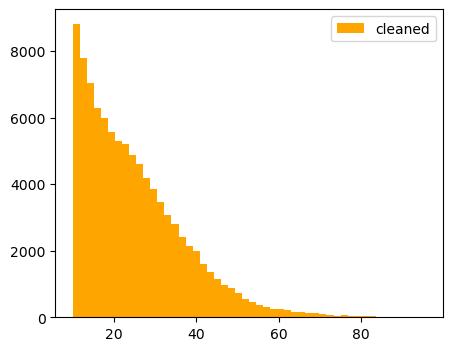

In [14]:
# Plotting the histogram

plt.figure(figsize=(5,4))
plt.hist(data_1D_clean, bins = 50, label = "cleaned", color = "orange")
plt.legend()
plt.show()

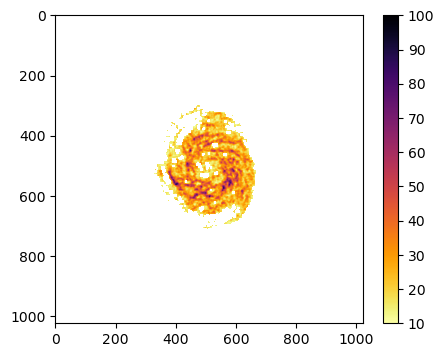

In [15]:
# Figure environment

fig, ax = plt.subplots(figsize=(5,4))

Z = ax.imshow(data_2D_clean, cmap = "inferno_r", vmin = 10., vmax = 100.)

plt.colorbar(Z)

plt.show()

#### 3. Getting the binary (1/0) image:

In [16]:
# Get unique values
print(np.unique(data_2D_clean))

# Generate the binary image:
data_2D_bin = np.where(data_2D_clean > 0., 1., 0.)

[10.000058 10.000121 10.00014  ... 95.18617  95.46323        nan]


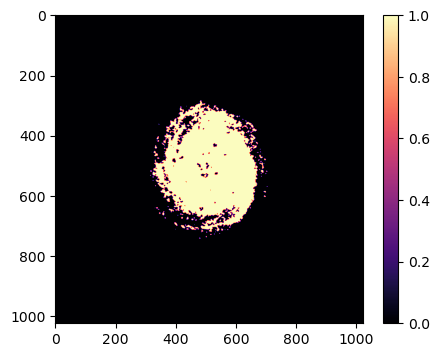

In [17]:
# Figure environment

fig, ax = plt.subplots(figsize=(5,4))

Z = ax.imshow(data_2D_bin, cmap = "magma", vmin = 0., vmax = 1.)

plt.colorbar(Z)

plt.show()

#### 4. Calculating the galaxy diameter (method 1):

In [18]:
# Get indices of the image where we have 1's

indices = np.where(data_2D_bin == 1)

print(indices[0])
print(indices[1])

[284 284 284 ... 742 742 742]
[482 483 484 ... 479 480 481]


In [19]:
# Get the min/max indices to carry out a rough estimate
min_x = np.min(indices[1])
max_x = np.max(indices[1])

min_y = np.min(indices[0])
max_y = np.max(indices[0])

print(min_x, max_x)
print(min_y, max_y)

315 703
284 742


In [20]:
# Calculate the diameter

diam_galaxy1 = np.mean([(max_x - min_x), (max_y - min_y)])

print("The galaxy diameter in pixels is: ", diam_galaxy1)

The galaxy diameter in pixels is:  423.0


#### 5. Calculating the galaxy diameter (method 2):

We will use skimage (centroid routines).


Properties:

https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

In [21]:
from skimage import filters
from skimage.measure import regionprops

In [22]:
# Let's get the centre of mass (work with original image)

# 1. Get a threshold value
threshold_value = filters.threshold_otsu(data_2D)

print(threshold_value)

# 2. Labeled foreground (actual feature)
labeled_foreground = (data_2D > threshold_value).astype(int)

print(np.unique(labeled_foreground))
print(labeled_foreground.shape)

# 3. Image properties/features
properties = regionprops(labeled_foreground, data_2D)

print(properties)
print("Area in pixels is:", properties[0].area)

14.1888685
[0 1]
(1024, 1024)
Area in pixels is: 75809


In [23]:
# 4. Get the centre of mass:
centre_of_mass = properties[0].centroid

print(centre_of_mass)

(507.307047975834, 516.493727657666)


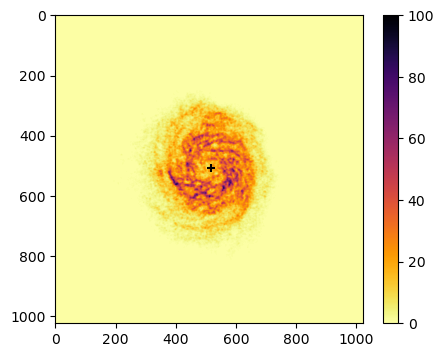

In [24]:
# 5. See the results on the image

fig, ax = plt.subplots(figsize=(5,4))

Z = ax.imshow(data_2D, cmap = "inferno_r", vmin = 0., vmax = 100.)
ax.scatter(centre_of_mass[1], centre_of_mass[0], marker = "+",\
          color = "black")

plt.colorbar(Z)

plt.show()

In [25]:
### 6. Diamater estimate:
print(properties[0].axis_major_length)
print(properties[0].axis_minor_length)

# Calculate the diameter

diam_galaxy2 = np.mean((properties[0].axis_major_length,\
                       properties[0].axis_minor_length))

print("The galaxy diameter in pixels is: ", diam_galaxy2)


359.50828262993946
308.0766142108508
The galaxy diameter in pixels is:  333.7924484203951


In [26]:
# Draw a circle:
# Angle
theta = np.linspace(0., 2*np.pi, 360)

# Radius:
rad_galaxy2 = diam_galaxy2/2

# Coord. of the circ.
x_circ = rad_galaxy2*np.cos(theta) + centre_of_mass[1]
y_circ = rad_galaxy2*np.sin(theta) + centre_of_mass[0]

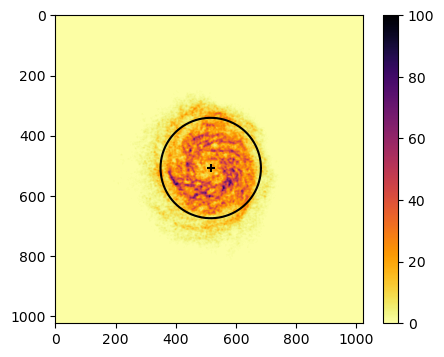

In [27]:
# 7. See the results on the image

fig, ax = plt.subplots(figsize=(5,4))

Z = ax.imshow(data_2D, cmap = "inferno_r", vmin = 0., vmax = 100.)
ax.scatter(centre_of_mass[1], centre_of_mass[0], marker = "+",\
          color = "black")
ax.plot(x_circ, y_circ, color = "black")

plt.colorbar(Z)

plt.show()

In [28]:
# Radius:
rad_galaxy1 = diam_galaxy1/2

# Coord. of the circ.
x_circ1 = rad_galaxy1*np.cos(theta) + centre_of_mass[1]
y_circ1 = rad_galaxy1*np.sin(theta) + centre_of_mass[0]

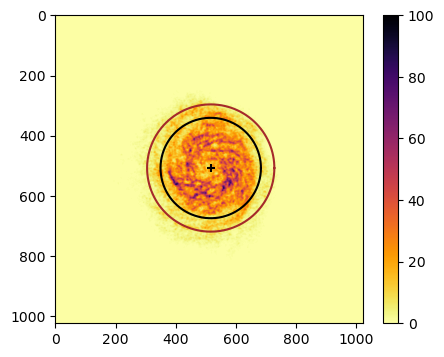

In [29]:
# 7. See the results on the image

fig, ax = plt.subplots(figsize=(5,4))

Z = ax.imshow(data_2D, cmap = "inferno_r", vmin = 0., vmax = 100.)
ax.scatter(centre_of_mass[1], centre_of_mass[0], marker = "+",\
          color = "black")
ax.plot(x_circ, y_circ, color = "black")
ax.plot(x_circ1, y_circ1, color = "brown")

plt.colorbar(Z)

plt.show()

## Estimate the physical diameter:

In [33]:
# Pixel resolution:

pixel_resolution = 4.166666768E-04*np.pi/180. # in radians

distance_galaxy = 12.2e3 # in kpc (wikipedia)

diam_galaxy_phy1 = distance_galaxy*diam_galaxy1*np.tan(pixel_resolution)
diam_galaxy_phy2 = distance_galaxy*diam_galaxy2*np.tan(pixel_resolution)

print("Diameter of galaxy in kpc is", diam_galaxy_phy1)
print("Diameter of galaxy in kpc is", diam_galaxy_phy2)

Diameter of galaxy in kpc is 37.52894315437352
Diameter of galaxy in kpc is 29.614368373825442


### Reference value:

https://ned.ipac.caltech.edu/byname?objname=NGC3184&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1